In [1]:
import os
os.environ['DRJIT_LIBLLVM_PATH'] = 'C:\\Program Files\\LLVM\\bin\\LLVM-C.dll'
#print(os.environ['DRJIT_LIBLLVM_PATH'])
import sionna
import mitsuba as mi
import drjit as dr
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, HTML
# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Antenna, AntennaArray
# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from Movement import *
from Visualization import *
from helper import *
from Channel import *
from Codebook import *
import math

In [2]:
#tf.random.set_seed(10)
itu_metal_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)
itu_concrete_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)

c = 299792458.0 # m/s
# tx and rx in cartesian coordinate
tx_position = [0,0.25,.94]
rx_position = [0,-0.25,.94]
N_t = 1
N_r = 32
L_r = 4
L_t = 1

initial_position_cartesian = cylindrical_to_cartesian([3.5, math.radians(56.41901378), 0])
initial_position_cartesian 

array([1.93590289, 2.91586694, 0.        ])

In [3]:
scene = load_scene('C:\\Users\\dehghani\\Documents\\test_scene\\scene.xml')

In [5]:
scene.frequency = 28e9
wavelength = c/scene.frequency
#print(scene.synthetic_array)
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

scene.tx_array = PlanarArray(num_rows=1,
                          num_cols = N_t,
                          vertical_spacing = wavelength/2,
                          horizontal_spacing= wavelength/2,
                          pattern="iso",
                          polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                          num_cols = N_r,
                          vertical_spacing= wavelength/2,
                          horizontal_spacing= wavelength/2,
                          pattern="iso",
                          polarization="V")

#scene.tx_array.show()

# Create transmitter
tx = Transmitter(name = "tx",
                 position = tx_position)


# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name = "rx",
              position = rx_position)

# Add receiver instance to scene
scene.add(rx)


In [6]:
wavelength

<tf.Tensor: shape=(), dtype=float32, numpy=0.010706873>

In [7]:
for rm in scene.radio_materials.values():
    if rm.name=='itu_metal' :
        print(f'Before: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        rm.scattering_coefficient= itu_metal_scattering_coefficient
        print(f'After: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        
    if rm.name=='itu_concrete' :
        rm.scattering_coefficient = itu_concrete_scattering_coefficient

   #     rm.scattering_pattern = BackscatteringPattern(alpha_r=20, alpha_i=30, lambda_=0.5)

Before: rm.name: itu_metal and   rm.scattering_coefficient = 0.0
After: rm.name: itu_metal and   rm.scattering_coefficient = 0.7070000171661377


In [8]:
params = mi.traverse(scene._scene)
positions = dr.unravel(mi.Point3f, params['mesh-Robot.vertex_positions'])

positions.x += initial_position_cartesian[0]
positions.y += initial_position_cartesian[1]
positions.z += initial_position_cartesian[2]

params['mesh-Robot.vertex_positions'] = dr.ravel(positions)
params.update()

[(PLYMesh[
    name = "Robot.ply",
    bbox = BoundingBox3f[
      min = [1.3859, 2.66587, 0.84],
      max = [2.4859, 3.16587, 1.04]
    ],
    vertex_count = 14,
    vertices = [280 B of vertex data],
    face_count = 12,
    faces = [144 B of face data],
    face_normals = 1
  ],
  {'vertex_positions'}),
 (Scene[
    children = [
      PathIntegrator[
        max_depth = 12,
        rr_depth = 5
      ],
      TwoSided[
        brdf[0] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ],
        brdf[1] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ]
      ],
      ConstantBackgroundEmitter[
        radiance = SRGBReflectanceSpectrum[
          value = [[1, 1, 1]]
        ],
        bsphere = BoundingSphere3f[
          center = [0, 0, 0.94],
          radius = 0.612427
        ]
      ],
      PLYMesh[
        na

In [9]:
scene._solver_paths = Solver(scene)
paths = scene.compute_paths(method='fibonacci', max_depth=1, num_samples=1e7, reflection=False, scattering=True,
                                    diffraction=False, los=False)
paths.normalize_delays = False
a, tau = paths.cir(los=False, reflection=False, diffraction=False, scattering=True)

In [10]:
scene.preview(paths, show_devices=True, show_paths=True) 

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [11]:
# a = [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps], tf.complex
a

<tf.Tensor: shape=(1, 1, 32, 1, 1, 17, 1), dtype=complex64, numpy=
array([[[[[[[ 3.0838148e-06+1.27177077e-06j],
            [ 2.4071453e-06+2.38687880e-06j],
            [-2.2831325e-06-2.21982646e-06j],
            [ 2.9279252e-06-1.71657143e-06j],
            [ 1.8880874e-06-2.80670747e-06j],
            [-1.0314601e-06-3.23260610e-06j],
            [ 2.4277394e-06+1.43856448e-06j],
            [-1.0262529e-06+2.07035714e-06j],
            [-2.3375055e-06+2.56949238e-06j],
            [-1.8707392e-06-1.57084901e-06j],
            [-3.0153228e-06+4.77349886e-07j],
            [-1.4977418e-06+2.79191431e-06j],
            [ 3.2856735e-07+2.93599328e-06j],
            [-1.8771650e-06-2.69937618e-06j],
            [-8.4535685e-07-1.89122613e-06j],
            [ 1.9881770e-06+2.53383701e-06j],
            [ 2.3434827e-06-2.59802619e-06j]]]],



         [[[[ 3.0454062e-06+1.36118217e-06j],
            [ 2.3357240e-06+2.45681372e-06j],
            [-2.2194431e-06-2.28350495e-06j],
       

In [12]:
# a_reshaped = [num_rx_ant, num_tx_ant, max_num_paths], tf.complex
a_reshaped = tf.squeeze(a, [0,1,3,6])
a_reshaped = tf.transpose(a_reshaped, perm=[2, 0, 1])
a_reshaped # (batch size (rays), receiving antennas, transmitting antennas)

<tf.Tensor: shape=(17, 32, 1), dtype=complex64, numpy=
array([[[ 3.0838148e-06+1.27177077e-06j],
        [ 3.0454062e-06+1.36118217e-06j],
        [ 3.0044057e-06+1.44943488e-06j],
        [ 2.9608486e-06+1.53645442e-06j],
        [ 2.9147716e-06+1.62216611e-06j],
        [ 2.8662139e-06+1.70649730e-06j],
        [ 2.8152172e-06+1.78937626e-06j],
        [ 2.7618248e-06+1.87073238e-06j],
        [ 2.7060821e-06+1.95049643e-06j],
        [ 2.6480361e-06+2.02860065e-06j],
        [ 2.5877364e-06+2.10497865e-06j],
        [ 2.5252350e-06+2.17956517e-06j],
        [ 2.4605843e-06+2.25229655e-06j],
        [ 2.3938396e-06+2.32311140e-06j],
        [ 2.3250577e-06+2.39194924e-06j],
        [ 2.2542972e-06+2.45875162e-06j],
        [ 2.1816184e-06+2.52346126e-06j],
        [ 2.1070828e-06+2.58602358e-06j],
        [ 2.0307541e-06+2.64638516e-06j],
        [ 1.9526969e-06+2.70449436e-06j],
        [ 1.8729779e-06+2.76030232e-06j],
        [ 1.7916655e-06+2.81376060e-06j],
        [ 1.7088280e-

# Receiving Codebook


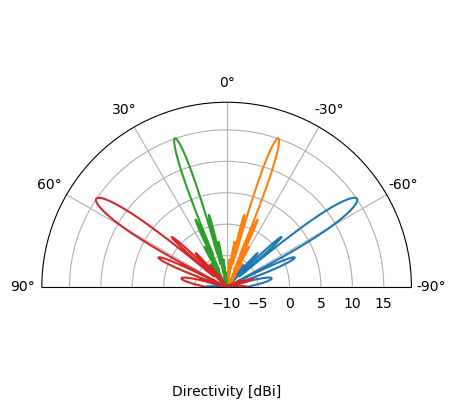

In [13]:
receiving_codebook = Codebook(L_max = L_r , N1 = N_r, az_min = -60, az_max = 60)
receiving_codebook_vectors, beam_degs = receiving_codebook.beamforming_vectors()
receiving_codebook.plot_beamforming_polar(receiving_codebook_vectors)

In [14]:
beam_degs

array([-56.41901378, -18.80633793,  18.80633793,  56.41901378])

In [15]:
receiving_matrix = np.vstack(receiving_codebook_vectors).T # converting the list into a matrix
receiving_codebook_matrix = np.reshape(receiving_matrix, (1, N_r, L_r)).astype(np.complex64)
receiving_codebook_matrix.shape  # (batch size, number of antennas, number of beams) 

(1, 32, 4)

In [16]:
receiving_signal = tf.matmul(receiving_codebook_matrix, a_reshaped, adjoint_a=True)
receiving_signal.shape
receiving_signal

<tf.Tensor: shape=(17, 4, 1), dtype=complex64, numpy=
array([[[ 5.4793708e-07+1.86409807e-07j],
        [ 4.8927484e-07+9.93832373e-07j],
        [ 3.2319781e-07+2.08693905e-07j],
        [ 4.0505540e-08+1.88155411e-07j]],

       [[ 4.4180555e-07+3.89705406e-07j],
        [ 7.0494252e-08+1.12507416e-06j],
        [ 2.1824857e-07+3.17283082e-07j],
        [-3.5024470e-08+1.89397042e-07j]],

       [[-4.2261317e-07-3.51877219e-07j],
        [-9.5792899e-08-1.04883441e-06j],
        [-2.2582509e-07-3.09048289e-07j],
        [ 2.9460040e-08-1.89339062e-07j]],

       [[ 4.9075027e-07-3.27339478e-07j],
        [ 1.1068945e-06+2.21098219e-07j],
        [ 3.6271138e-07-1.29452289e-07j],
        [ 1.7405681e-07+8.24935569e-08j]],

       [[ 2.9872749e-07-5.06157789e-07j],
        [ 1.0890802e-06-2.80672310e-07j],
        [ 2.7042228e-07-2.74119600e-07j],
        [ 1.9258968e-07-1.30768285e-09j]],

       [[-2.1156745e-07-5.50487300e-07j],
        [ 4.5856774e-07-1.03108198e-06j],
        [-4.

In [17]:
# tau = [batch_size, num_rx, num_tx, max_num_paths]
tau = tf.squeeze(tau)
tau

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([2.1017378e-08, 2.0760298e-08, 2.1771838e-08, 2.0741091e-08,
       2.0794317e-08, 2.0745031e-08, 2.3830964e-08, 2.0866302e-08,
       2.0375127e-08, 2.0068160e-08, 2.2474392e-08, 2.1855406e-08,
       2.3032833e-08, 2.1249996e-08, 2.2530649e-08, 2.1585603e-08,
       2.0262178e-08], dtype=float32)>

In [18]:
# Reshape the tensor to a 2D array
reshaped_array = tf.reshape(receiving_signal, (tau.shape[0], L_r * L_t))
columns = [f'{i},{j}' for i in range(1, L_t + 1) for j in range(1, L_r + 1)]
df1 = pd.DataFrame(reshaped_array.numpy(), columns=columns)
df1 = df1.set_index(pd.Index(tau))
df1

,"1,1","1,2","1,3","1,4"
2.101738e-08,5.479371e-07+1.864098e-07j,4.892748e-07+9.938324e-07j,3.231978e-07+2.086939e-07j,4.050554e-08+1.881554e-07j
2.076030e-08,4.418056e-07+3.897054e-07j,7.049425e-08+1.125074e-06j,2.182486e-07+3.172831e-07j,-3.502447e-08+1.893970e-07j
2.177184e-08,-4.226132e-07-3.518772e-07j,-9.579290e-08-1.048834e-06j,-2.258251e-07-3.090483e-07j,2.946004e-08-1.893391e-07j
2.074109e-08,4.907503e-07-3.273395e-07j,1.106895e-06+2.210982e-07j,3.627114e-07-1.294523e-07j,1.740568e-07+8.249356e-08j
2.079432e-08,2.987275e-07-5.061578e-07j,1.089080e-06-2.806723e-07j,2.704223e-07-2.741196e-07j,1.925897e-07-1.307683e-09j
2.074503e-08,-2.115675e-07-5.504873e-07j,4.585677e-07-1.031082e-06j,-4.667143e-08-3.822774e-07j,1.186892e-07-1.517006e-07j
2.383096e-08,4.386632e-07+1.979835e-07j,3.264522e-07+8.635323e-07j,2.922016e-07+2.312122e-07j,2.162591e-08+1.855934e-07j
2.086630e-08,-1.644628e-07+3.688105e-07j,-7.209518e-07+2.762652e-07j,-1.530095e-07+1.951688e-07j,-1.230299e-07+1.489752e-08j
2.037513e-08,-3.839298e-07+4.677399e-07j,-1.151946e-06+1.133595e-07j,-3.095349e-07+2.295266e-07j,-1.905746e-07-2.828517e-08j
2.006816e-08,-3.384251e-07-2.593820e-07j,-1.068798e-07-8.083406e-07j,-1.651646e-07-2.078669e-07j,1.509193e-08-1.318369e-07j


In [19]:
channel_magnitude_df = abs_complex_columns(df1)
channel_magnitude_df

,"1,1","1,2","1,3","1,4"
2.101738e-08,5.787777e-07,1.107742e-06,3.847206e-07,1.924660e-07
2.076030e-08,5.891201e-07,1.127280e-06,3.850987e-07,1.926083e-07
2.177184e-08,5.499268e-07,1.053200e-06,3.827634e-07,1.916173e-07
2.074109e-08,5.899042e-07,1.128760e-06,3.851200e-07,1.926161e-07
2.079432e-08,5.877362e-07,1.124666e-06,3.850581e-07,1.925941e-07
2.074503e-08,5.897432e-07,1.128457e-06,3.851159e-07,1.926141e-07
2.383096e-08,4.812721e-07,9.231787e-07,3.726136e-07,1.868491e-07
2.086630e-08,4.038183e-07,7.720713e-07,2.479975e-07,1.239286e-07
2.037513e-08,6.051303e-07,1.157511e-06,3.853496e-07,1.926622e-07
2.006816e-08,4.263926e-07,8.153759e-07,2.654958e-07,1.326979e-07


In [20]:
#m = channel_magnitude_df.query('index > 11e-9').max()
m = channel_magnitude_df.max()
m

1,1    6.099457e-07
1,2    1.166600e-06
1,3    3.853496e-07
1,4    1.926622e-07
dtype: float64

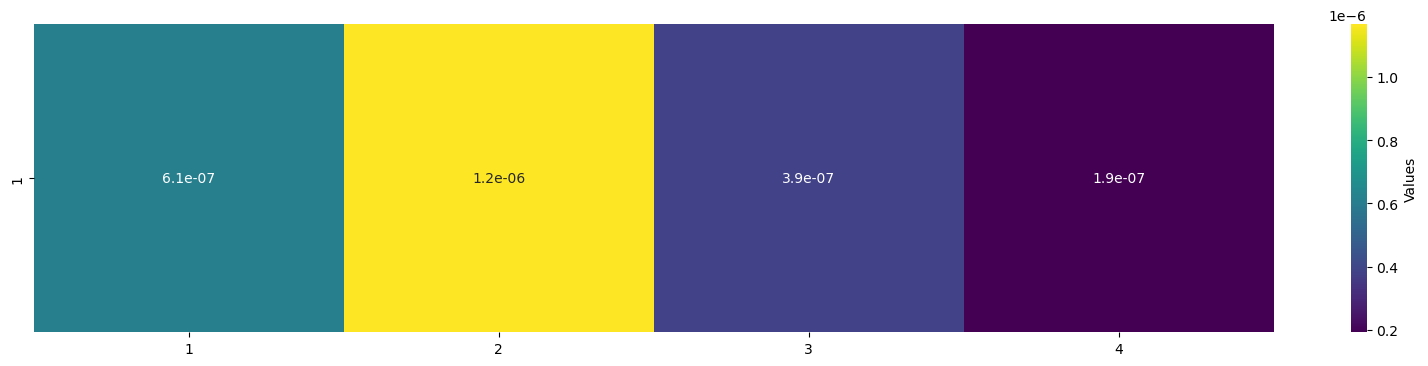

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the data into a 2D array --> L_t*L_r
data_matrix = m.values.reshape(L_t, L_r)

# Convert index labels to integers
index_labels = [tuple(map(int, index.split(','))) for index in m.index]
rows, cols = zip(*index_labels)

plt.figure(figsize=(20, 4))  
# Create a heatmap using seaborn
sns.heatmap(data_matrix, cmap='viridis', annot=True, cbar_kws={'label': 'Values'})

plt.xticks(np.arange(L_r) + 0.5, range(1, L_r+1))
plt.yticks(np.arange(L_t) + 0.5, range(1, L_t+1))

# Display the heatmap
plt.show()

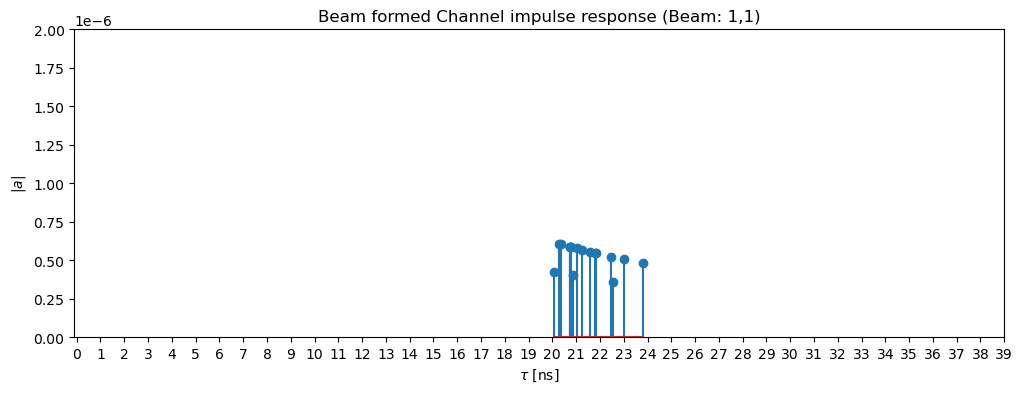

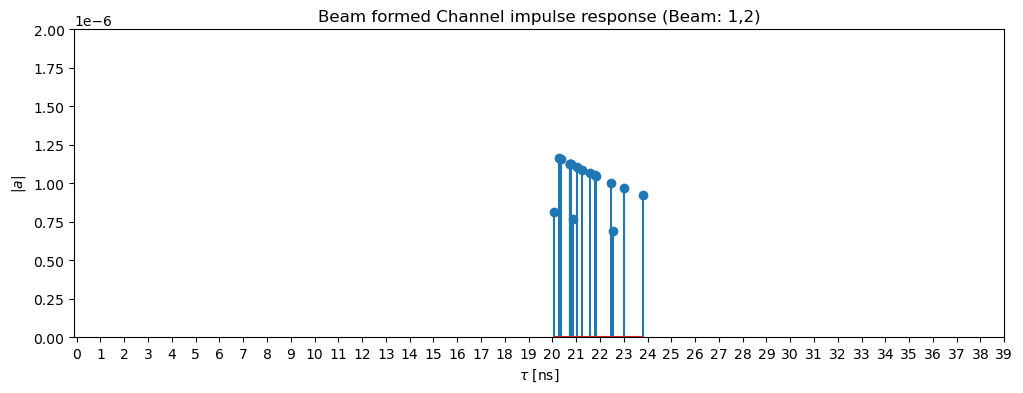

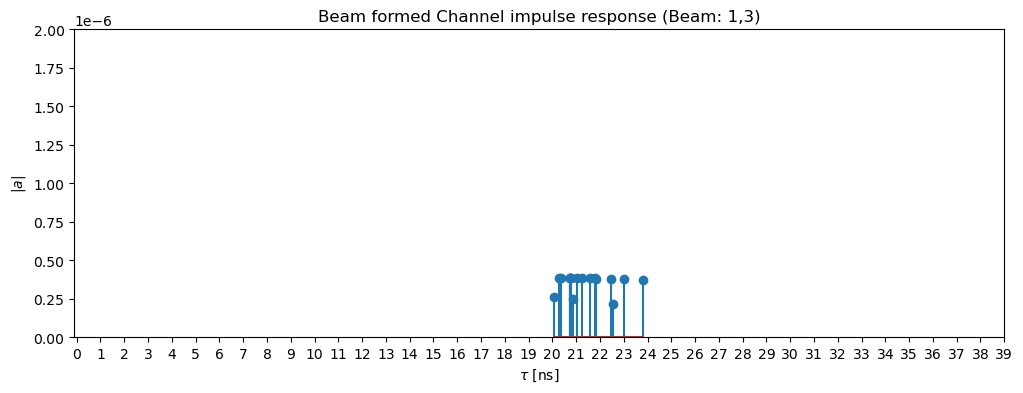

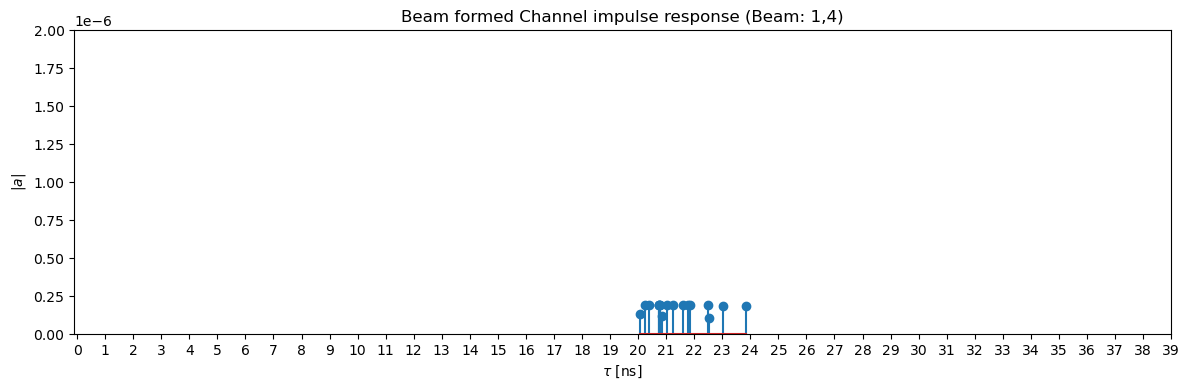

In [22]:
for column in channel_magnitude_df.columns:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))   
    ax.set_title(f"Beam formed Channel impulse response (Beam: {column})")
    ax.stem(channel_magnitude_df.index*1e9, channel_magnitude_df[column])
    ax.set_xlim([-0.1, 39])
    ax.set_ylim([-2e-12, 2e-6])
    ax.set_xlabel(r"$\tau$ [ns]")
    ax.set_ylabel(r"$|a|$")
    ax.set_xticks(np.arange(0, 40, 1))

# subplots do not overlap
plt.tight_layout()
plt.show()